In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [2]:
start = '2015-01-01'
end = '2025-03-28'


stock = 'VBL.NS'
data = yf.download(stock, start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data.reset_index(inplace=True)

In [4]:
data

Price,Date,Close,High,Low,Open,Volume
Ticker,,VBL.NS,VBL.NS,VBL.NS,VBL.NS,VBL.NS
0,2016-11-08,24.897339,25.561087,22.586411,23.298924,305744118
1,2016-11-09,23.534628,24.382600,21.294137,21.294137,13691733
2,2016-11-10,23.642990,24.973196,23.475022,24.165861,7757505
3,2016-11-11,23.875980,24.382596,23.296215,23.515659,5469221
4,2016-11-15,23.737812,24.095424,23.298926,23.732393,6065128
...,...,...,...,...,...,...
2069,2025-03-21,537.950012,552.000000,533.000000,547.000000,10054240
2070,2025-03-24,531.099976,547.750000,529.650024,545.000000,5386711
2071,2025-03-25,517.150024,535.000000,511.649994,534.500000,6675687


C:\Users\DHRUVIL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 0.0491
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0049
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0044
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0031
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0033
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0023
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.0025
Epoch 14/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0024
Epoch 15/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - l

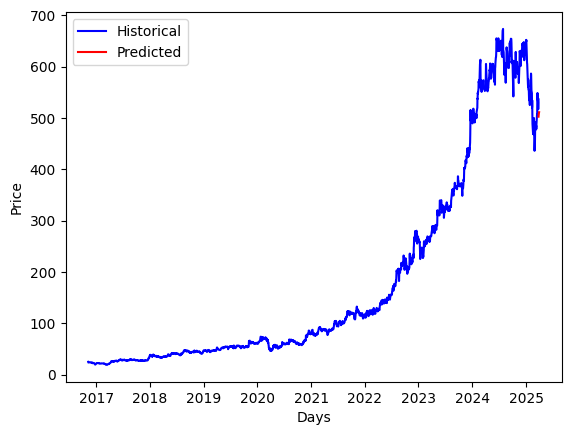

In [11]:
sequence_length = 100
data_training = pd.DataFrame(data["Close"][:int(len(data) * 0.70)])
data_testing = pd.DataFrame(data["Close"][int(len(data) * 0.70): int(len(data))])


scaler = MinMaxScaler()
data_training_array = scaler.fit_transform(data_training.values.reshape(-1, 1))


x_train = []
y_train = []

for i in range(data_training_array.shape[0] - 100):
    x_train.append(data_training_array[i: 100 + i, 0])
    y_train.append(data_training_array[100 + i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(60, activation='relu', return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(80, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1)]
)

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=30, batch_size=30)

past_days = data_training.tail(100)
new_df = past_days._append(data_testing, ignore_index=True)
input_data = scaler.fit_transform(new_df)

x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i - 100: i])
    y_test.append(input_data[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

y_predicted = model.predict(x_test)

scale_factor = 1/0.02099617
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

x_future = [input_data[-100:]]

future_predictions = []
duration = 5
for i in range(duration):
    x_future_array = np.array(x_future)
    x_future_array = np.reshape(x_future_array, (x_future_array.shape[0], x_future_array.shape[1], 1))
    future_prediction = model.predict(x_future_array)

    future_predictions.append(future_prediction[0, 0])

    x_future[0] = np.concatenate((x_future[0][1:], future_prediction), axis=None)

future_predictions_array = np.array(future_predictions)

y_future = scaler.inverse_transform(future_predictions_array.reshape(-1, 1))

future_time_indices = pd.date_range(start=data["Date"].iloc[-1], periods=duration, freq="D")

plt.plot(data["Date"], data["Close"], label='Historical', color='b')
plt.plot(future_time_indices, y_future, label='Predicted', color='r')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
movingAvg_100 = data.Close.rolling(100).mean()

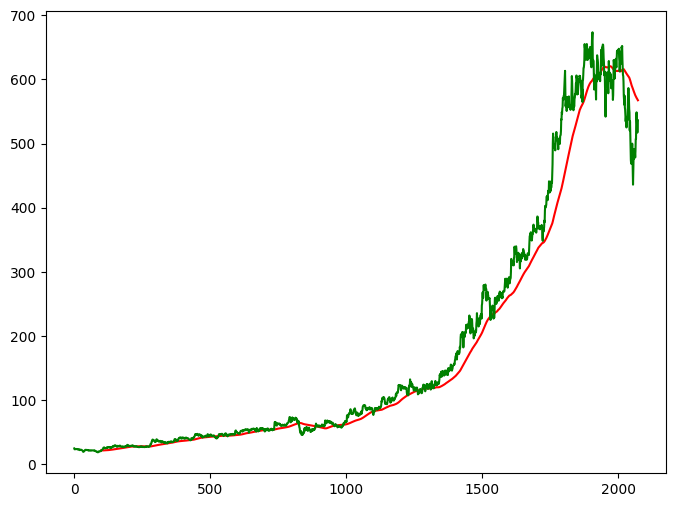

In [13]:
plt.figure(figsize=(8,6))
plt.plot(movingAvg_100, 'r')
plt.plot(data.Close, 'g')
plt.show()

In [14]:
movingAvg_200 = data.Close.rolling(200).mean()

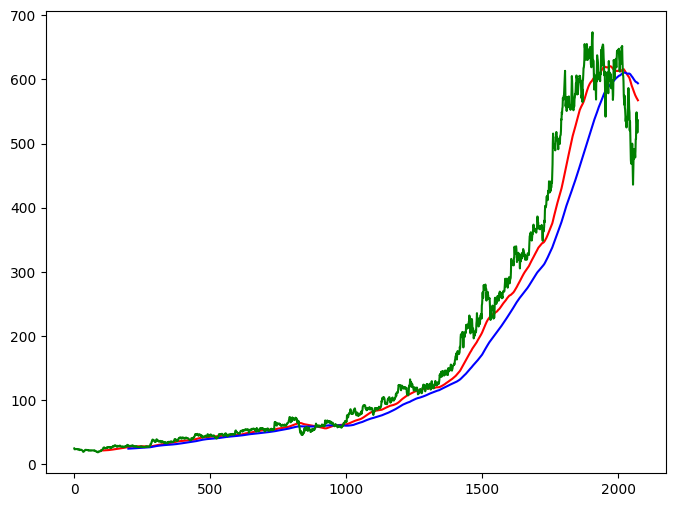

In [15]:
plt.figure(figsize=(8,6))
plt.plot(movingAvg_100, 'r')
plt.plot(movingAvg_200,'b')
plt.plot(data.Close,'g')
plt.show()

In [16]:
model.save('Stock Predictions Mod Model.keras')